## Import Libraries

In [1]:
%matplotlib inline

import gym
import math
import random
import time
import numpy as np
import matplotlib 
import matplotlib.pyplot as plt

from collections import namedtuple
from itertools import count
from PIL import Image

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as T


## Set up display

In [2]:
is_ipython = "inline" in matplotlib.get_backend()
if is_ipython: from IPython import display
    

## Deep Q-Network

In [3]:
class DQN (nn.Module) :
    
    def __init__ ( self , img_height , img_width ) :
        super().__init__()
        
        k = 4       # kernel size variable
        s = 2       # stride variable
        
        self.cnn1 = nn.Conv2d ( in_channels = 6 , out_channels = 4 , kernel_size = k , stride = s )
        
        new_h = math.ceil( (img_height - k)/s ) + 1
        new_w = math.ceil( (img_width - k)/s ) + 1
 
        self.fc1 = nn.Linear( in_features = 4 * new_h * new_w , out_features = 16 )

        # self.fc1 = nn.Linear( in_features = 3 * img_height * img_width , out_features = 24 )
        # self.fc2 = nn.Linear( in_features = 24 , out_features = 32 )
        # self.fc3 = nn.Linear( in_features = 32 , out_features = 32 )
        
        self.out = nn.Linear( in_features = 16 , out_features = 2 )
        
    def forward ( self , t ) :
        
        t = F.relu( self.cnn1(t) )

        t = t.flatten( start_dim = 1 )        
        t = F.relu( self.fc1(t) )
        
        # t = F.relu( self.fc2(t) )
        # t = F.relu( self.fc3(t) )
        
        t = self.out(t)
        return t
        

## Experience Class

In [4]:
Experience = namedtuple ( 'Experience' , ( 'state' , 'action' , 'next_state' , 'reward' ) )


In [5]:
e = Experience(2,4,1,3) #Example


## Replay Memory

In [6]:
class ReplayMemory () :
    
    def __init__ (self , capacity) :
        
        self.capacity = capacity
        self.memory = []
        self.push_count = 0
        
    def push(self , experience) :
        
        if len(self.memory) < self.capacity :
            self.memory.append (experience)
        else :
            self.memory[self.push_count % self.capacity] = experience
        self.push_count += 1
        
    def sample (self , batch_size) :
        return random.sample(self.memory , batch_size)
        
    def can_provide_sample (self , batch_size) :
        return len(self.memory) >= batch_size
    

## Epsilon Greedy Strategy

In [7]:
class EpsilonGreedyStrategy () :
    
    def __init__ (self , start , end , decay) : 
        
        self.start = start
        self.end = end
        self.decay = decay
        
    def get_exploration_rate (self , current_step) :
        
        return self.end + ( self.start - self.end ) * math.exp( -1 * self.decay * current_step )
    

## Reinforcement Learning Agent

In [8]:
class Agent () :
    
    def __init__ (self , strategy , num_actions , device ) :
        
        self.current_step = 0
        self.strategy = strategy
        self.num_actions = num_actions
        self.device = device
        
    def select_action(self , state , policy_net) :
        
        rate = self.strategy.get_exploration_rate (self.current_step)
        self.current_step += 1
        
        if rate > random.random() :
            action = random.randrange (self.num_actions)
            return torch.tensor([action]).to(self.device)
        else :
            with torch.no_grad() :
                return policy_net(state).argmax(dim = 1).to(self.device)
            

## Environment Manager

In [9]:
class CartPoleEnvManager () :
    
    def __init__ (self , device) :
        self.device = device
        self.env = gym.make("CartPole-v0").unwrapped
        self.env.reset()
        self.current_screen = None
        self.done = False
        
    def reset (self) :
        self.env.reset()
        self.current_screen = None
        
    def close (self) :
        self.env.close ()
        
    def render (self , mode = 'human') :
        return self.env.render(mode)
    
    def num_actions_available (self) :
        return self.env.action_space.n
    
    def take_action (self , action) :
        _ , reward , self.done , _ = self.env.step(action.item())
        return torch.tensor([reward] , device = self.device)
        
    def just_starting (self) :
        return self.current_screen is None
    
    def get_state (self) :
        
        if self.just_starting() or self.done :
            self.current_screen = self.get_processed_screen()
            black_screen = torch.zeros_like(self.current_screen)
            return torch.cat([black_screen , black_screen] , 1)   #black_screen
        
        else :
            s1 = self.current_screen
            s2 = self.get_processed_screen()
            self.current_screen = s2
            return torch.cat([s1 , s2] , 1)   #s2 - s1
        
    def get_screen_height (self) :
        screen = self.get_processed_screen()
        return screen.shape[2]
    
    def get_screen_width (self) :
        screen = self.get_processed_screen()
        return screen.shape[3]
    
    def get_processed_screen(self) :
        screen = self.render('rgb_array').transpose((2,0,1))
        screen = self.crop_screen(screen)
        return self.transform_screen_data(screen)
    
    def crop_screen(self , screen) : 
        screen_height = screen.shape[1]
        
        top = int(screen_height * 0.4)
        bottom = int(screen_height * 0.8)
        screen = screen[: , top:bottom , :]
        return screen
            
    def transform_screen_data (self , screen) :
        
        screen = np.ascontiguousarray(screen , dtype = np.float32) / 255
        screen = torch.from_numpy(screen)
        
        resize = T.Compose( [T.ToPILImage() , T.Resize( (40 , 90) ) , T.ToTensor()] )
        
        return resize(screen).unsqueeze(0).to(self.device)
           

## Example of non-processed screen

C:\Users\USER\Anaconda3\lib\site-packages\gym\logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


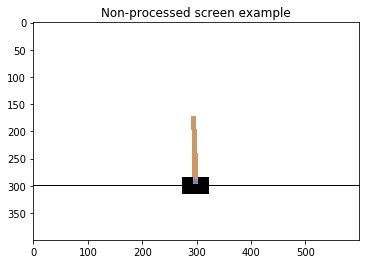

In [10]:
device = torch.device("cpu") # ("cuda" if torch.cuda.is_available() else "cpu")
em = CartPoleEnvManager(device)
em.reset()
screen = em.render('rgb_array')

plt.figure()
plt.imshow(screen)
plt.title('Non-processed screen example')
plt.show()


## Example of processed screen

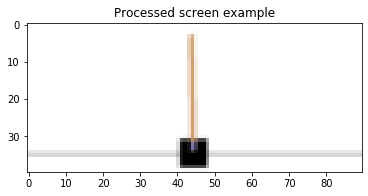

In [11]:
screen = em.get_processed_screen()

plt.figure()
plt.imshow(screen.squeeze(0).permute(1,2,0).cpu() , interpolation = 'none')
plt.title('Processed screen example')
plt.show()

## Example of starting state

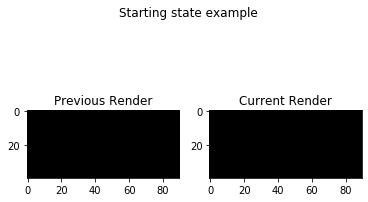

In [12]:
# screen = em.get_state()

# plt.figure()
# plt.imshow(screen.squeeze(0).permute(1,2,0) , interpolation = 'none')
# plt.title('Starting state example')
# plt.show()

screen = em.get_state()

fig=plt.figure()

fig.add_subplot(1, 2, 1)
plt.imshow(screen.squeeze(0)[0:3].permute(1,2,0) , interpolation = 'none')
plt.title('Previous Render')

fig.add_subplot(1, 2, 2)
plt.imshow(screen.squeeze(0)[3:6].permute(1,2,0) , interpolation = 'none')
plt.title('Current Render')

plt.suptitle('Starting state example')
plt.show()

## Example of non-starting state

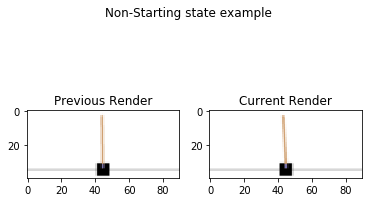

In [13]:
# for i in range(5) :
#     em.take_action(torch.tensor( [1] ))
# screen = em.get_state()
# 
# plt.figure()
# plt.imshow(screen.squeeze(0).permute(1,2,0) , interpolation = 'none')
# plt.title('Non-Starting state example')
# plt.show()

for i in range(5) :
    em.take_action(torch.tensor( [1] ))
screen = em.get_state()

fig=plt.figure()

fig.add_subplot(1, 2, 1)
plt.imshow(screen.squeeze(0)[0:3].permute(1,2,0) , interpolation = 'none')
plt.title('Previous Render')

fig.add_subplot(1, 2, 2)
plt.imshow(screen.squeeze(0)[3:6].permute(1,2,0) , interpolation = 'none')
plt.title('Current Render')

plt.suptitle('Non-Starting state example')
plt.show()


## Example of end state

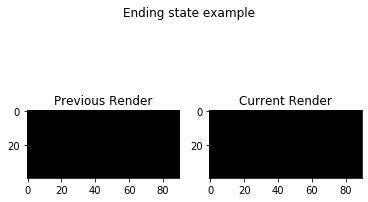

In [14]:
# em.done = True
# screen = em.get_state()

# plt.figure()
# plt.imshow(screen.squeeze(0).permute(1,2,0) , interpolation = 'none')
# plt.title('Ending state example')
# plt.show()
# em.close()

em.done = True
screen = em.get_state()

fig=plt.figure()

fig.add_subplot(1, 2, 1)
plt.imshow(screen.squeeze(0)[0:3].permute(1,2,0) , interpolation = 'none')
plt.title('Previous Render')

fig.add_subplot(1, 2, 2)
plt.imshow(screen.squeeze(0)[3:6].permute(1,2,0) , interpolation = 'none')
plt.title('Current Render')

plt.suptitle('Ending state example')
plt.show()


## Utility Functions

### Plotting

In [15]:
def plot (values , moving_avg_period) :
    plt.figure(2)
    plt.clf()
    plt.title('Training...')
    plt.xlabel('Episode')
    plt.ylabel('Duration')
    plt.plot(values)
    
    moving_avg = get_moving_average(moving_avg_period , values)
    plt.plot(moving_avg)
    plt.pause(0.001)
    print(" Episode : " , len(values) , "\n" , moving_avg_period , " episode moving average : " , moving_avg[-1] )
    if is_ipython : display.clear_output(wait = True)
        
def get_moving_average(period , values) :
    values = torch.tensor(values , dtype = torch.float)
    
    if len(values) >= period :
        moving_avg = values.unfold(dimension = 0 , size = period , step = 1).mean(dim=1).flatten(start_dim = 0)
        moving_avg = torch.cat( (torch.zeros(period-1) , moving_avg) )
        return moving_avg.numpy()
        
    else :
        moving_avg = torch.zeros(len(values))
        return moving_avg.numpy()
    

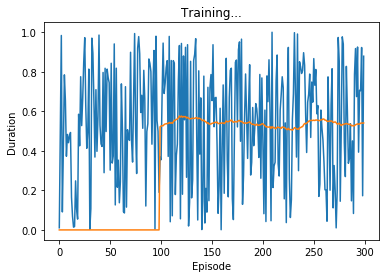

 Episode :  300 
 100  episode moving average :  0.54109746


In [16]:
plot(np.random.rand(300) , 100)

### Tensor Processing

In [17]:
def extract_tensors(experiences) :
    
    batch = Experience( *zip( *experiences ) )
    
    t1 = torch.cat(batch.state)
    t2 = torch.cat(batch.action)
    t3 = torch.cat(batch.reward) 
    t4 = torch.cat(batch.next_state) 
    
    return ( t1 , t2 , t3 , t4 )

### Q-value Calculator

In [18]:
class QValues () :
    device = torch.device("cpu") # ("cuda" if torch.cuda.is_available() else "cpu")

    @staticmethod
    def get_current(policy_net , states , actions) :
        
        return policy_net(states).gather(dim = 1 , index = actions.unsqueeze(-1))
    
    @staticmethod
    def get_next(target_net , next_states) :
        
        final_state_positions = next_states.flatten(start_dim = 1).max(dim = 1)[0].eq(0).type(torch.bool)
        non_final_state_positions = (final_state_positions == False)
        non_final_states = next_states[non_final_state_positions]
        
        batch_size = next_states.shape[0]
        values = torch.zeros(batch_size).to(QValues.device)
        values[non_final_state_positions] = target_net( non_final_states ).max(dim = 1)[0].detach()
        
        return values
            

## Main Program

In [19]:
batch_size = 128
gamma = 0.999
eps_start = 0.05
eps_end = 0.01
eps_decay = 0.0006
target_update = 10
memory_size = 50000
lr = 0.001
num_episodes = 1000

device = torch.device("cpu") # ("cuda" if torch.cuda.is_available() else "cpu")

em = CartPoleEnvManager (device)
strategy = EpsilonGreedyStrategy (eps_start , eps_end , eps_decay)
agent = Agent (strategy , em.num_actions_available() , device)
memory = ReplayMemory (memory_size)

policy_net = DQN (em.get_screen_height() , em.get_screen_width()).to(device)
policy_net.load_state_dict(torch.load('Cart_Pole_model.pt'))
target_net = DQN (em.get_screen_height() , em.get_screen_width()).to(device)
target_net.load_state_dict(policy_net.state_dict())
target_net.eval()
optimizer = optim.Adam(params = policy_net.parameters() , lr = lr)

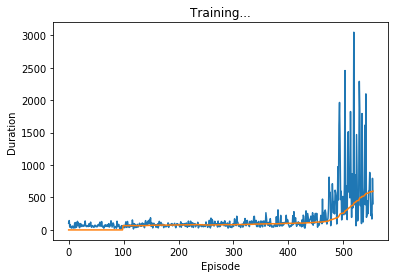

 Episode :  555 
 100  episode moving average :  597.6


In [ ]:
start_time = time.time()

episode_durations = []
for episode in range(num_episodes) :
    em.reset()
    state = em.get_state()
    
    for timestep in count() :
        action = agent.select_action(state , policy_net) 
        reward = em.take_action(action)
        next_state = em.get_state()
        memory.push(Experience(state , action , next_state , reward))
        state = next_state
        
        if memory.can_provide_sample(batch_size) :
            experiences = memory.sample(batch_size)
            states , actions , rewards , next_states = extract_tensors(experiences)
            
            current_q_values = QValues.get_current(policy_net , states , actions)
            next_q_values = QValues.get_next(target_net , next_states)
            target_q_values = ( next_q_values * gamma ) + rewards
            
            loss = F.mse_loss(current_q_values , target_q_values.unsqueeze(1))
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
        if em.done :
            episode_durations.append(timestep)
            plot(episode_durations , 100)
            break
            
    if episode % target_update == 0 :
        target_net.load_state_dict(policy_net.state_dict())
        torch.save(policy_net.state_dict() , 'Cart_Pole_model.pt')
        
em.close()

end_time = time.time()
Total_time = end_time - start_time

print("Time taken for training =" , Total_time , " s")
                         

## Display Trained Cart and Pole model

In [26]:
policy_net = DQN (em.get_screen_height() , em.get_screen_width()).to(device)
policy_net.load_state_dict(torch.load('Cart_Pole_model.pt'))
average_timestep = 0
total_timestep = 0
example_set_size = 20

for i in range(example_set_size) :

    em.reset()
    state = em.get_state()

    for timestep in count() :
        action = agent.select_action(state , policy_net) 
        reward = em.take_action(action)
        next_state = em.get_state()
        memory.push(Experience(state , action , next_state , reward))
        state = next_state

        if em.done :
            print("No. timesteps pole balanced : " , timestep)
            total_timestep += timestep
            break
                
em.close()

average_timestep = total_timestep / example_set_size
print("Average timestep : " , average_timestep)


No. timesteps pole balanced :  524
No. timesteps pole balanced :  1511
No. timesteps pole balanced :  676
No. timesteps pole balanced :  1334
No. timesteps pole balanced :  957
No. timesteps pole balanced :  500
No. timesteps pole balanced :  1687
No. timesteps pole balanced :  180
No. timesteps pole balanced :  539
No. timesteps pole balanced :  195
No. timesteps pole balanced :  2257
No. timesteps pole balanced :  403
No. timesteps pole balanced :  887
No. timesteps pole balanced :  1087
No. timesteps pole balanced :  392
No. timesteps pole balanced :  589
No. timesteps pole balanced :  709
No. timesteps pole balanced :  1291
No. timesteps pole balanced :  552
No. timesteps pole balanced :  718
Average timestep :  849.4


In [23]:
# torch.save(policy_net.state_dict() , 'Best2_Cart_Pole_model.pt') # Save copy of model if model is really good


# DONE
